In [5]:
# from transformers import AutoTokenizer, AutoModelForMaskedLM
# tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
# model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

In [6]:
import re
def evaluate_sent_level(predicted_string, alignment_string):
    # # Example usage
    # alignment_string = "5-6 3-4 25p22 5-7 2p3 25p21 4-5 11-14 12-13 13-15 27p20 9-11 25p23 8-8 22-25 20-27 17-18 1-1 28-28 26p20 18-19 6p9 1-2 7-10 10-12 21-24 15-17 14-16 23-26"
    # predicted_string = "5-6 3-4 25-22 ..."  # Replace with your model's predicted alignments

    def parse_alignments(alignment_string):
        sure_alignments = set()
        possible_alignments = set()

        # Split the string into individual alignments
        alignments = alignment_string.split()

        for alignment in alignments:
            if 'p' in alignment:
                # Possible alignment
                aligned_words = tuple(map(int, alignment.split('p')))
                possible_alignments.add(aligned_words)
            else:
                # Sure alignment
                aligned_words = tuple(map(int, alignment.split('-')))
                sure_alignments.add(aligned_words)
        return sure_alignments, possible_alignments

    def calculate_f1(predicted_alignments, sure_alignments, possible_alignments):
        a_and_s = len(predicted_alignments.intersection(sure_alignments))
        a_and_p = len(predicted_alignments.intersection(possible_alignments))
        prec = a_and_p / len(predicted_alignments) if len(predicted_alignments) > 0 else 0
        rec = a_and_s / len(sure_alignments) if len(sure_alignments) > 0 else 0

        if prec + rec == 0:
            return 0
        return 2 * (prec * rec) / (prec + rec), prec, rec

    def calculate_aer(predicted_alignments, sure_alignments, possible_alignments):
        a_and_s = len(predicted_alignments.intersection(sure_alignments))
        a_and_p = len(predicted_alignments.intersection(possible_alignments))
        return 1 - (a_and_s + a_and_p) / (len(predicted_alignments) + len(sure_alignments))

    
    # Parse alignments
    sure_alignments, possible_alignments = parse_alignments(alignment_string)
    predicted_alignments = parse_alignments(predicted_string)[0]  # Assuming model predicts only sure alignments

    # Calculate metrics
    f1_score, prec, rec = calculate_f1(predicted_alignments, sure_alignments, possible_alignments.union(sure_alignments))
    aer = calculate_aer(predicted_alignments, sure_alignments, possible_alignments.union(sure_alignments))

    # print("F1 Score:", f1_score)
    # print("AER:", aer)
    return {"F1 Score": f1_score, "AER": aer, "Precision": prec, "Recall": rec}

def evaluate_corpus_level(pred_list, align_list):
    # # Example usage
    # alignment_string = "5-6 3-4 25p22 5-7 2p3 25p21 4-5 11-14 12-13 13-15 27p20 9-11 25p23 8-8 22-25 20-27 17-18 1-1 28-28 26p20 18-19 6p9 1-2 7-10 10-12 21-24 15-17 14-16 23-26"
    # predicted_string = "5-6 3-4 25-22 ..."  # Replace with your model's predicted alignments

    def parse_alignments(alignment_string):
        sure_alignments = set()
        possible_alignments = set()

        # Split the string into individual alignments
        alignments = alignment_string.split()

        for alignment in alignments:
            if 'p' in alignment:
                # Possible alignment
                aligned_words = tuple(map(int, alignment.split('p')))
                possible_alignments.add(aligned_words)
            else:
                # Sure alignment
                aligned_words = tuple(map(int, alignment.split('-')))
                sure_alignments.add(aligned_words)

        return sure_alignments, possible_alignments

    def compare(predicted_alignments, sure_alignments, possible_alignments):
        a_and_s = len(predicted_alignments.intersection(sure_alignments))
        a_and_p = len(predicted_alignments.intersection(possible_alignments))
        
        return a_and_p, a_and_s

    def calculate_aer(predicted_alignments, sure_alignments, possible_alignments):
        a_and_s = len(predicted_alignments.intersection(sure_alignments))
        a_and_p = len(predicted_alignments.intersection(possible_alignments))
        return 1 - (a_and_s + a_and_p) / (len(predicted_alignments) + len(sure_alignments))

    sum_a_and_s = 0
    sum_a_and_p = 0
    sum_len_a = 0
    sum_len_s = 0
    
    for pred, align in zip(pred_list, align_list):
        # Parse alignments
        sure_alignments, possible_alignments = parse_alignments(align)
        predicted_alignments = parse_alignments(pred)[0]
        possible_alignments = possible_alignments.union(sure_alignments)
        
        a_and_p, a_and_s = compare(predicted_alignments, sure_alignments, possible_alignments)
        sum_a_and_s += a_and_s
        sum_a_and_p += a_and_p
        sum_len_a += len(predicted_alignments)
        sum_len_s += len(sure_alignments)
    
    precision = sum_a_and_p / sum_len_a
    recall = sum_a_and_s / sum_len_s
    aer = 1 - (sum_a_and_s + sum_a_and_p) / (sum_len_a + sum_len_s)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return {"F1 Score": f1_score, "AER": aer, "Precision": precision, "Recall": recall}


def format_alignments(alignments):
        """
        Formats the set of alignment tuples into a string where each alignment is represented
        by 'source-target' and source/target indices are one-based.
        """
        formatted = ' '.join(f'{src+1}-{tgt+1}' for src, tgt in sorted(alignments))
        return formatted
    
def grow_diag_final_balanced(forward_alignments, reverse_alignments, src_len, tgt_len):
    """
    A more balanced implementation of Grow-diag-final heuristic.
    """
    def get_neighbors(src, tgt):
        """Generate direct neighbors for a given source-target position."""
        neighbors = []
        for d_src in [-1, 0, 1]:
            for d_tgt in [-1, 0, 1]:
                if d_src == 0 and d_tgt == 0:
                    continue  # Skip the position itself
                n_src, n_tgt = src + d_src, tgt + d_tgt
                if 0 <= n_src < src_len and 0 <= n_tgt < tgt_len:
                    neighbors.append((n_src, n_tgt))
        return neighbors

    # Step 1: Intersection as the starting point
    combined_alignments = forward_alignments & reverse_alignments

    # Step 2: Grow - selectively
    unaligned_src = set(range(src_len))
    unaligned_tgt = set(range(tgt_len))
    for (src, tgt) in combined_alignments:
        unaligned_src.discard(src)
        unaligned_tgt.discard(tgt)

    def is_neighbor_aligned(src, tgt):
        for neighbor in get_neighbors(src, tgt):
            if neighbor in combined_alignments:
                return True
        return False

    added = True
    while added:
        added = False
        new_points = set()
        for src in unaligned_src:
            for tgt in unaligned_tgt:
                if ((src, tgt) in forward_alignments or (src, tgt) in reverse_alignments) and is_neighbor_aligned(src, tgt):
                    new_points.add((src, tgt))
                    added = True

        for point in new_points:
            combined_alignments.add(point)
            unaligned_src.discard(point[0])
            unaligned_tgt.discard(point[1])

    # Step 3: Final - cautiously add unique alignments without causing conflicts
    for src in range(src_len):
        for tgt in range(tgt_len):
            if (src, tgt) in forward_alignments ^ reverse_alignments and not is_neighbor_aligned(src, tgt):
                combined_alignments.add((src, tgt))

    return format_alignments(combined_alignments)

def grow_diag_final_and(forward_alignments, reverse_alignments, src_len, tgt_len):
    """
    Implements the Grow-diag-final-and heuristic for combining forward and reverse alignments.
    This variant is more conservative, focusing on high-precision alignments.
    """
    def get_neighbors(src, tgt):
        """Generate neighboring positions for a given source-target position."""
        neighbors = []
        for d_src in [-1, 0, 1]:
            for d_tgt in [-1, 0, 1]:
                if d_src == 0 and d_tgt == 0:
                    continue  # Skip the position itself
                n_src, n_tgt = src + d_src, tgt + d_tgt
                if 0 <= n_src < src_len and 0 <= n_tgt < tgt_len:
                    neighbors.append((n_src, n_tgt))
        return neighbors

    # Start with the strict intersection of forward and reverse alignments
    combined_alignments = forward_alignments & reverse_alignments

    # Initialize unaligned sets for source and target
    unaligned_src = {i for i in range(src_len)} - {src for src, _ in combined_alignments}
    unaligned_tgt = {i for i in range(tgt_len)} - {tgt for _, tgt in combined_alignments}

    added = True
    while added:
        added = False
        new_points = set()
        for src in unaligned_src:
            for tgt in unaligned_tgt:
                if (src, tgt) in forward_alignments and (src, tgt) in reverse_alignments:
                    neighbors = get_neighbors(src, tgt)
                    if any((n_src, n_tgt) in combined_alignments for n_src, n_tgt in neighbors):
                        new_points.add((src, tgt))
                        added = True

        for point in new_points:
            combined_alignments.add(point)
            unaligned_src.discard(point[0])
            unaligned_tgt.discard(point[1])

    return format_alignments(combined_alignments)




In [7]:
import torch
import torch.optim as optim

# Assuming x and y are your data tensors
# x: tensor of shape [m, dim]
# y: tensor of shape [n, dim]
def find_avg_vector2(x, y):
    x = x.detach()
    y = y.detach()
    
    def compute_l2_distance(tensor_a, tensor_b):
        return torch.norm(tensor_a - tensor_b, dim=1)

    def compute_pair_wise_l2_distance(tensor_a, tensor_b):
        return torch.norm(tensor_a.unsqueeze(1) - tensor_b.unsqueeze(0), dim=2)
    
    def objective_initialization(c, x, y, alpha):
        combined_x_y = torch.cat([x, y], dim=0)
        xy_distances = compute_pair_wise_l2_distance(x, y)
        c_to_xy_distances = compute_l2_distance(combined_x_y, c)
        distance_diff = (xy_distances.view(-1).unsqueeze(1) - c_to_xy_distances.unsqueeze(0)).reshape(-1).abs().mean()
        return alpha * c_to_xy_distances.mean() + (1 - alpha) * distance_diff

    def variance_objective(c, x, y, lambda_weight):
        combined_x_y = torch.cat([x, y], dim=0)
        xy_distances = compute_pair_wise_l2_distance(x, y)
        c_to_xy_distances = compute_l2_distance(combined_x_y, c)
        var_c_to_xy = torch.var(c_to_xy_distances)
        var_diff = (xy_distances.view(-1).unsqueeze(1) - c_to_xy_distances.unsqueeze(0)).reshape(-1).var()
        return lambda_weight * var_c_to_xy + (1 - lambda_weight) * var_diff

    # Parameters
    alpha = 0.5
    lambda_weight = 0.5
    learning_rate = 0.01
    max_iterations = 200
    convergence_threshold = 1e-6

    # Initialize c
    c = torch.mean(torch.cat([x.detach(), y.detach()], dim=0), dim=0).requires_grad_(True).to(x)

    # Optimizer
    optimizer = optim.Adam([c], lr=learning_rate)

    # Iterative Process
    previous_loss_all = float('inf')

    for iteration in range(max_iterations):
        # Step 1: Initialization Loop
        previous_loss_median = float('inf')
        for _idx in range(max_iterations):
            optimizer.zero_grad()
            loss_init = objective_initialization(c, x, y, alpha)
            loss_init.backward()
            optimizer.step()

            # Early Stopping for Step 1
            if torch.abs(previous_loss_median - loss_init) < convergence_threshold:
                break
            previous_loss_median = loss_init

        # Step 2: Variance Minimization Loop
        previous_loss_var = float('inf')
        for _idx in range(max_iterations):
            optimizer.zero_grad()
            loss_variance = variance_objective(c, x, y, lambda_weight)
            loss_variance.backward()
            optimizer.step()

            # Early Stopping for Step 2
            if torch.abs(previous_loss_var - loss_variance) < convergence_threshold:
                break
            previous_loss_var = loss_variance

        # Convergence Check for Overall Process
        if torch.abs(loss_variance - previous_loss_all) < convergence_threshold:
            # print(f"Converged in {iteration+1} overall iterations")
            break
        previous_loss_all = loss_variance
    # print(iteration)
    return c

def find_avg_vector_xy(x, y):
    x = x.detach()
    y = y.detach()
    
    def compute_l2_distance(tensor_a, tensor_b):
        return torch.norm(tensor_a - tensor_b, dim=1)

    def compute_pair_wise_l2_distance(tensor_a, tensor_b):
        return torch.norm(tensor_a.unsqueeze(1) - tensor_b.unsqueeze(0), dim=2)
    
    def objective_initialization(c, x, y, alpha):
        combined_x_y = torch.cat([x, y], dim=0)
        xy_distances = compute_pair_wise_l2_distance(combined_x_y, combined_x_y)
        mask = torch.ones_like(xy_distances, dtype=torch.bool)
        mask.fill_diagonal_(0)
        xy_distances = xy_distances[mask].reshape(-1)
        c_to_xy_distances = compute_l2_distance(combined_x_y, c)
        distance_diff = (xy_distances.unsqueeze(1) - c_to_xy_distances.unsqueeze(0)).reshape(-1).abs().mean()
        return alpha * c_to_xy_distances.mean() + (1 - alpha) * distance_diff

    def variance_objective(c, x, y, lambda_weight):
        combined_x_y = torch.cat([x, y], dim=0)
        xy_distances = compute_pair_wise_l2_distance(combined_x_y, combined_x_y)
        mask = torch.ones_like(xy_distances, dtype=torch.bool)
        mask.fill_diagonal_(0)
        xy_distances = xy_distances[mask].reshape(-1)
        
        c_to_xy_distances = compute_l2_distance(combined_x_y, c)
        var_c_to_xy = torch.var(c_to_xy_distances)
        var_diff = (xy_distances.unsqueeze(1) - c_to_xy_distances.unsqueeze(0)).reshape(-1).var()
        return lambda_weight * var_c_to_xy + (1 - lambda_weight) * var_diff

    # Parameters
    alpha = 0.5
    lambda_weight = 0.5
    learning_rate = 0.01
    max_iterations = 200
    convergence_threshold = 1e-6

    # Initialize c
    c = torch.mean(torch.cat([x.detach(), y.detach()], dim=0), dim=0).requires_grad_(True).to(x)

    # Optimizer
    optimizer = optim.Adam([c], lr=learning_rate)

    # Iterative Process
    previous_loss_all = float('inf')

    for iteration in range(max_iterations):
        # Step 1: Initialization Loop
        previous_loss_median = float('inf')
        for _idx in range(max_iterations):
            optimizer.zero_grad()
            loss_init = objective_initialization(c, x, y, alpha)
            loss_init.backward()
            optimizer.step()

            # Early Stopping for Step 1
            if torch.abs(previous_loss_median - loss_init) < convergence_threshold:
                break
            previous_loss_median = loss_init

        # Step 2: Variance Minimization Loop
        previous_loss_var = float('inf')
        for _idx in range(max_iterations):
            optimizer.zero_grad()
            loss_variance = variance_objective(c, x, y, lambda_weight)
            loss_variance.backward()
            optimizer.step()

            # Early Stopping for Step 2
            if torch.abs(previous_loss_var - loss_variance) < convergence_threshold:
                break
            previous_loss_var = loss_variance

        # Convergence Check for Overall Process
        if torch.abs(loss_variance - previous_loss_all) < convergence_threshold:
            # print(f"Converged in {iteration+1} overall iterations")
            break
        previous_loss_all = loss_variance
    # print(iteration)
    return c


def find_avg_vector_x(x, y):
    # only  src (x)
    x = x.detach()
    y = y.detach()
    
    def compute_l2_distance(tensor_a, tensor_b):
        return torch.norm(tensor_a - tensor_b, dim=1)

    def compute_pair_wise_l2_distance(tensor_a, tensor_b):
        return torch.norm(tensor_a.unsqueeze(1) - tensor_b.unsqueeze(0), dim=2)
    
    def objective_initialization(c, x, y, alpha):
        x_to_x_distances = compute_pair_wise_l2_distance(x, x) 
        mask = torch.ones_like(x_to_x_distances, dtype=torch.bool)
        mask.fill_diagonal_(0)
        x_to_x_distances = x_to_x_distances[mask].reshape(-1)
        
        c_to_x_distances = compute_l2_distance(x, c)
        distance_diff = (x_to_x_distances.view(-1).unsqueeze(1) - c_to_x_distances.unsqueeze(0)).reshape(-1).abs().mean()
        return alpha * c_to_x_distances.mean() + (1 - alpha) * distance_diff

    def variance_objective(c, x, y, lambda_weight):
        x_to_x_distances = compute_pair_wise_l2_distance(x, x) 
        mask = torch.ones_like(x_to_x_distances, dtype=torch.bool)
        mask.fill_diagonal_(0)
        x_to_x_distances = x_to_x_distances[mask].reshape(-1)
        c_to_x_distances = compute_l2_distance(x, c)
        var_c_to_x = torch.var(c_to_x_distances)
        var_diff = (x_to_x_distances.view(-1).unsqueeze(1) - c_to_x_distances.unsqueeze(0)).reshape(-1).var()
        return lambda_weight * var_c_to_x + (1 - lambda_weight) * var_diff

    # Parameters
    alpha = 0.5
    lambda_weight = 0.5
    learning_rate = 0.01
    max_iterations = 200
    convergence_threshold = 1e-6

    # Initialize c
    c = torch.mean(torch.cat([x.detach(), y.detach()], dim=0), dim=0).requires_grad_(True).to(x)

    # Optimizer
    optimizer = optim.Adam([c], lr=learning_rate)

    # Iterative Process
    previous_loss_all = float('inf')

    for iteration in range(max_iterations):
        # Step 1: Initialization Loop
        previous_loss_median = float('inf')
        for _idx in range(max_iterations):
            optimizer.zero_grad()
            loss_init = objective_initialization(c, x, y, alpha)
            loss_init.backward()
            optimizer.step()

            # Early Stopping for Step 1
            if torch.abs(previous_loss_median - loss_init) < convergence_threshold:
                break
            previous_loss_median = loss_init

        # Step 2: Variance Minimization Loop
        previous_loss_var = float('inf')
        for _idx in range(max_iterations):
            optimizer.zero_grad()
            loss_variance = variance_objective(c, x, y, lambda_weight)
            loss_variance.backward()
            optimizer.step()

            # Early Stopping for Step 2
            if torch.abs(previous_loss_var - loss_variance) < convergence_threshold:
                break
            previous_loss_var = loss_variance

        # Convergence Check for Overall Process
        if torch.abs(loss_variance - previous_loss_all) < convergence_threshold:
            # print(f"Converged in {iteration+1} overall iterations")
            break
        previous_loss_all = loss_variance
    # print(iteration)
    return c

In [8]:
# Analyze the hallucination labels
import matplotlib.pyplot as plt
from OTAlign.src.model_parts import *
import math
import torch
import numpy as np
import ot
from tqdm import tqdm
def pmi_align(src_rep, mt_rep):
    src_rep = torch.stack(src_rep, dim=0).cuda()
    mt_rep = torch.stack(mt_rep, dim=0).cuda()
    
    def pmi_matrix(out_src, out_tgt):
        out_src.div_(torch.norm(out_src, dim=-1).unsqueeze(-1))
        out_tgt.div_(torch.norm(out_tgt, dim=-1).unsqueeze(-1))
            
        sim = torch.matmul(out_src, out_tgt.transpose(-1, -2))
        sim = torch.softmax(sim.view(-1), dim=0).view(sim.size())
        
        probs_src = torch.sum(sim, dim = 1)
        probs_tgt = torch.sum(sim, dim = 0)
        
        repeat_probs_src = probs_src.unsqueeze(1).expand(-1, sim.size(-1))
        repeat_probs_tgt = probs_tgt.repeat(sim.size(0), 1)
        scores = torch.log(sim) - torch.log(repeat_probs_tgt) - torch.log(repeat_probs_src)
        
        scores = (scores - scores.min()) / (scores.max() - scores.min())
        
        return scores
    
    out_src = src_rep
    out_tgt = mt_rep
    
    out_src.div_(torch.norm(out_src, dim=-1).unsqueeze(-1))
    out_tgt.div_(torch.norm(out_tgt, dim=-1).unsqueeze(-1))

    dot_prod = pmi_matrix(out_src, out_tgt)
    
    # A = iter_max(dot_prod.numpy())
    # align_words = np.nonzero(A)
    # align_words2 = set()
    # for i in range(len(align_words[0])):
    #   align_words2.add((sub2word_map_src[align_words[0][i]], sub2word_map_tgt[align_words[1][i]]))
    

    argmax_srctgt = torch.argmax(dot_prod, dim=-1)
    argmax_tgtsrc = torch.argmax(dot_prod, dim=-2)

    align_words_srctgt = set()
    align_words_tgtsrc = set()
    for i, j in enumerate(argmax_srctgt):
        i = int(i) + 1
        j = int(j) + 1
        align_words_srctgt.add( (str(i), str(j))) 
    
    for i, j in enumerate(argmax_tgtsrc):
        i = int(i) + 1
        j = int(j) + 1
        align_words_tgtsrc.add( (str(j), str(i)) )
    
    align_words = align_words_srctgt.intersection(align_words_tgtsrc)
    
    # indices = sinkhorn(dot_prod)
    # align_words = set()
    # for p in indices:
    #   align_words.add( (sub2word_map_src[p[0]], sub2word_map_tgt[p[1]]) )

    alignStr = ""
    for p in align_words:
        alignStr += str(p[0]) + "-" + str(p[1]) + " "
    
    return alignStr        


def map_original_to_tokenized(x1, x2):
    mapping = {}
    tokenized_index = 0
    original_index = 0

    while original_index < len(x2) and tokenized_index < len(x1):
        original_word = x2[original_index]
        subword_sequence = ''

        indices = []
        while tokenized_index < len(x1) and (subword_sequence != original_word):
            subword = x1[tokenized_index].lstrip('##')
            if subword_sequence + subword == original_word[:len(subword_sequence + subword)]:
                subword_sequence += subword
                indices.append(tokenized_index)
                tokenized_index += 1
            else:
                break

        if not indices:
            tokenized_index += 1
        else:
            mapping[original_index] = indices

        original_index += 1

    return mapping

def map_original_to_sentencepiece(x1, x2):
    mapping = {}
    tokenized_index = 0
    original_index = 0

    # Replace with the actual underscore character used in your SentencePiece tokenization
    sentence_piece_underscore = '▁'

    while original_index < len(x2) and tokenized_index < len(x1):
        original_word = x2[original_index]
        subword_sequence = ''

        indices = []
        while tokenized_index < len(x1) and (subword_sequence != original_word):
            subword = x1[tokenized_index].lstrip(sentence_piece_underscore)
            if subword and (subword_sequence + subword == original_word[:len(subword_sequence) + len(subword)]):
                subword_sequence += subword
                indices.append(tokenized_index)
            tokenized_index += 1

        # Special handling for tokens that are just the SentencePiece underscore or punctuation
        if not indices and x1[tokenized_index - 1].strip(sentence_piece_underscore) == '':
            indices.append(tokenized_index - 1)

        if indices:
            mapping[original_index] = indices

        original_index += 1

    return mapping


def get_word_embeddings(sentence, model, tokenizer):
    # Tokenize the sentence and get corresponding IDs
    inputs = tokenizer(sentence, return_tensors="pt")
    # tokens = inputs.tokens()[1:-1]
    tokens = tokenizer.tokenize(sentence)
    mapping = map_original_to_tokenized(tokens, sentence.split())

    # Get BERT embeddings for each token
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    embeddings = outputs['hidden_states'][8].squeeze(0)[1:-1]

    assert len(embeddings) == len(tokens)
    
    word_embeddings = []
    for original_idx in range(len(sentence.split())):
        subword_indices = mapping[original_idx]
        subword_embeddings = [embeddings[idx] for idx in subword_indices]
        averaged_embedding = torch.mean(torch.stack(subword_embeddings), dim=0)
        word_embeddings.append(averaged_embedding)

    assert len(word_embeddings) == len(sentence.split(" "))
    return word_embeddings

# word_level_emb = get_word_embeddings("This is an example sentence , which is meant to be encoded . Subwords are not a problem for this model .", model, model.tokenizer)
import torch

def find_avg_vector_cosine_similarity(vectors, vectors2=None):
    def cosine_distance(x, vectors):
        # Normalize the vectors
        x_norm = x / x.norm(dim=1, keepdim=True)
        vectors_norm = vectors / vectors.norm(dim=1, keepdim=True)
        # Compute cosine similarity and convert to distance
        cosine_sim = torch.mm(vectors_norm, x_norm.t())
        return 1 - cosine_sim

    def objective_function_uniform_cosine(x, vectors):
        distances = cosine_distance(x, vectors).squeeze()
        return torch.var(distances)

    def objective_function_sum_cosine(x, vectors):
        distances = cosine_distance(x, vectors).squeeze()
        return distances.mean()

    def objective_function_sum_uniform_cosine(x, vectors):
        distances = cosine_distance(x, vectors).squeeze()
        return distances.mean() + torch.var(distances)

    combined_vectors = torch.cat([vectors, vectors2], dim=0)
    x = torch.mean(combined_vectors.detach(), dim=0, keepdim=True).clone().detach().requires_grad_(True)

    optimizer = torch.optim.Adam([x], lr=0.01)
    for _ in range(3000):  # Number of iterations
        optimizer.zero_grad()
        loss = objective_function_sum_uniform_cosine(x, combined_vectors.detach())
        loss.backward()
        optimizer.step()

    optimizer = torch.optim.Adam([x], lr=0.01)
    for _ in range(3000):  # Number of iterations
        optimizer.zero_grad()
        loss = objective_function_uniform_cosine(x, combined_vectors.detach())
        loss.backward()
        optimizer.step()

    return x.detach().squeeze(0)


def find_avg_vector_cuda(vectors, vectors2=None):
    def objective_function_uniform_l2(x, vectors, ):
        distances = torch.norm(vectors - x, dim=1)
        return torch.var(distances)
        
    def objective_function_sum_l2(x, vectors, ):
        distances = torch.norm(vectors - x, dim=1)
        return distances.mean()
    
    def objective_function_sum_uniform_l2(x, vectors, ):
        distances = torch.norm(vectors - x, dim=1)
        return distances.mean() + torch.var(distances)
    
    
    combined_vectors = torch.cat([vectors, vectors2], dim=0)
    x = torch.mean(combined_vectors.detach(), dim=0, keepdim=True).clone().detach().requires_grad_(True)
    
    optimizer = torch.optim.Adam([x], lr=0.01)
    
    over_all_loss = float('inf')
    for _ in range(200):
        previous_loss = float('inf')
        for _ in range(3000):  # Number of iterations
            optimizer.zero_grad()
            loss = objective_function_sum_uniform_l2(x, combined_vectors.detach())
            loss.backward()
            optimizer.step()
            if torch.abs(previous_loss - loss) < 1e-6:
                break
            previous_loss = loss
            
        optimizer = torch.optim.Adam([x], lr=0.01)
        previous_loss = float('inf')
        for _ in range(3000):  # Number of iterations
            optimizer.zero_grad()
            loss = objective_function_uniform_l2(x, combined_vectors.detach())
            loss.backward()
            optimizer.step()
            if torch.abs(previous_loss - loss) < 1e-6:
                break
            previous_loss = loss

        if torch.abs(over_all_loss - loss) < 1e-6:
            break
        over_all_loss = loss
        
    return x.detach().squeeze(0)

def get_predicted_alignment(P, method='l2r', thres=None, is_fwd=False):
    # Apply argmax along each row
    null_idx = P.shape[1] - 1
    if method == 'l2r':
        alignment_indices = np.argmax(P, axis=1)
        
        # Generate alignment string
        if is_fwd:
            alignment_string = ' '.join(f'{i+1}-{j+1}' for i, j in enumerate(alignment_indices) if j != null_idx and sum(P[i]) > 0)
        else:
            alignment_string = ' '.join(f'{j+1}-{i+1}' for i, j in enumerate(alignment_indices) if j != null_idx and sum(P[i]) > 0)
        
    elif method == 'r2f':
        alignment_indices = np.argmax(P, axis=0)
        # Generate alignment string
        if is_fwd:
            alignment_string = ' '.join(f'{j+1}-{i+1}' for i, j in enumerate(alignment_indices) if j != null_idx and sum(P[:, i]) > 0)
        else:
            alignment_string = ' '.join(f'{i+1}-{j+1}' for i, j in enumerate(alignment_indices) if j != null_idx and sum(P[:, i]) > 0)
        
    elif method == 'thres':
        assert thres is not None
        P_thres = P.copy()
        thres = P_thres[:, :-1].sum(axis=1)[:, np.newaxis] * thres  # can be designed
        bin_P = (P_thres >= thres).astype(int)
        alignments = []
        # Iterate over the matrix
        for i in range(bin_P.shape[0]):  # For each source (row)
            if P_thres[i].argmax(-1) == null_idx:
                continue
            for j in range(bin_P.shape[1]):  # For each target (column)
                if j == null_idx:
                    continue
                if bin_P[i, j] == 1:
                    # Record the alignment, adjusting index to be one-based
                    if is_fwd:
                        alignments.append(f"{i+1}-{j+1}")
                    else:
                        alignments.append(f"{j+1}-{i+1}")
        # Join all alignments into a string
        alignment_string = ' '.join(alignments)
    
    return alignment_string

def get_join_alignments(fwd_align, rev_align, method='union'):
    fwd_align_pairs = rank_align_pairs(fwd_align)
    rev_align_pairs = rank_align_pairs(rev_align)
    
    if method == 'union':
        align_pairs = list(set(fwd_align_pairs).union(set(rev_align_pairs)))
    elif method == 'intersection':
        align_pairs = list(set(fwd_align_pairs).intersection(set(rev_align_pairs)))
    elif method == '':
        align_pairs = list(set(fwd_align_pairs).symmetric_difference(set(rev_align_pairs)))
    else:
        raise NotImplementedError
    
    align_pairs = sorted(align_pairs, key=lambda x: x[0])
    align_string = ' '.join([f'{pair[0]}-{pair[1]}' for pair in align_pairs])
    return align_string
    
    
def rank_align_pairs(align):
    align_pairs = align.split()
    align_pairs = [pair.split('-') for pair in align_pairs if 'p' not in pair]
    align_pairs = [(int(pair[0]), int(pair[1])) for pair in align_pairs]
    align_pairs = sorted(align_pairs, key=lambda x: x[0] * 1000 + x[1])
    return align_pairs

m = 0.5
epsilon = 0.1
numItermax = 3000
stopThr = 1e-8

def get_ot_align(src_rep, mt_rep, simple_avg_unk=False, method='l2r',  thres=0.3, is_fwd=False):
    def get_ot_map(src_rep, mt_rep, m=m, epsilon=epsilon, numItermax=numItermax, stopThr=stopThr, w1=None, w2=None):
        def convert_to_numpy(s1_weights, s2_weights, C):
            if torch.is_tensor(s1_weights):
                s1_weights = s1_weights.to('cpu').numpy()
                s2_weights = s2_weights.to('cpu').numpy()
            if torch.is_tensor(C):
                C = C.to('cpu').numpy()
            return s1_weights, s2_weights, C
        
        # src_rep = src_rep.copy()
        # mt_rep = mt_rep.copy()
        
        
        
        # C = 1 - pmi_matrix(mt_rep, src_rep).cpu()

        # return 1 - C, C
        
        C = compute_distance_matrix_l2(mt_rep, src_rep, 0.0) # len(mt_rep) x len(src_rep)
        # C = compute_distance_matrix_cosine(mt_rep, src_rep, 0.0)
        
        
        if simple_avg_unk:
            def get_equal_n_min_dist(ser_rep, ref_rep):
                x = torch.cat([ser_rep, ref_rep], dim=0)
                b = (x.norm(dim=1)[0].unsqueeze(0) ** 2 - x.norm(dim=1)[1:] ** 2) / 2
                A = x[0].unsqueeze(0) - x[1:]
                A_pinv = A.pinverse()
                d = (A_pinv @ ( A @ x[0] - b)).norm()
                return d
                # # d = (A_pinv @ ( A @ x[0].unsqueeze(1) - b)).norm()
                
                # d = (x[0] - A_pinv @ b).norm()
                # f = (x[0] - A_pinv @ b)
                
                # d = A_pinv @ A @ x[0] - A_pinv @ A @ A_pinv @ b
                # A_pinv @ A @ x[0] - A_pinv @ b
                # (A_pinv @ ( A @ x[0] - b )).norm()
                # # d = (f - (torch.eye(f.shape[0]) - A_pinv @ A ) @ f).norm()
                # d = (A_pinv @ A @ f).norm()
                # return d


            avg_C = C.mean()
            C = torch.cat([C, torch.ones(C.shape[0], 1).to(C) * avg_C], dim=1)
        
        #  NOTE: s1 correspoins to mt
        #  NOTE: s2 correspoins to src
        
        s1_weights, s2_weights = compute_weights_uniform(mt_rep, src_rep)
        # s1_weights, s2_weights = compute_weights_norm(mt_rep, src_rep)
        
        s1_weights = s1_weights / s1_weights.sum() 
        s1_weights *= 1.5
        
        if simple_avg_unk:
            s2_weights = torch.cat([s2_weights, torch.tensor([1.0]).to(C)], dim=0)   

        s2_weights[-1] = 0.0
        s2_weights = s2_weights / s2_weights.sum()
        # s2_weights *= 1.5
        
        # s2_weights[:-1].sum() * 0.5
        s1_weights, s2_weights, C = convert_to_numpy(s1_weights, s2_weights, C)
        # m = np.min((np.sum(s1_weights), np.sum(s2_weights))) * m
        # m = s2_weights.sum() / (s1_weights.sum() + s2_weights.sum())
        
        m = 0.9999
        # P = ot.partial.entropic_partial_wasserstein(s1_weights, s2_weights, C, reg=epsilon, m=m, stopThr=stopThr, numItermax=numItermax)
        
        P = ot.sinkhorn(s1_weights, s2_weights, C, epsilon, numItermax=numItermax)
        # P = ot.emd(s1_weights, s2_weights, C)
        # P = min_max_scaling(P)
        # P = ot.unbalanced.sinkhorn_stabilized_unbalanced(s1_weights, s2_weights, C, reg=epsilon, reg_m=(0.1, 0.1), stopThr=stopThr, numItermax=numItermax)
        # P = min_max_scaling(P)
        
        # P = ot.emd(s1_weights / s1_weights.sum(), s2_weights / s2_weights.sum(), C)
        # tmp = 0
        
        return P, C
    
    src_rep = torch.stack(src_rep, dim=0).cuda()
    mt_rep = torch.stack(mt_rep, dim=0).cuda()

    
    if not simple_avg_unk:
        # avg_src_rep = find_avg_vector_cosine_similarity(src_rep, mt_rep)
        avg_src_rep = find_avg_vector_cuda(src_rep, mt_rep).detach()
        # avg_src_rep = find_avg_vector_xy(src_rep, mt_rep).detach()
        avg_src_rep = avg_src_rep.to(mt_rep)
        src_rep = torch.cat([src_rep, avg_src_rep.unsqueeze(0)], dim=0)
        
    P, C = get_ot_map(src_rep, mt_rep)
    
    predicted_align = get_predicted_alignment(P, method=method, thres=thres, is_fwd=is_fwd)
    return predicted_align, P, C



src = 'de'
tgt = 'en'
num_samples = len(open(f'PMI-Align/data/{src}-{tgt}/text.{src}', 'r').readlines())


results = []
results_fwd = []
results_rev = []
results_union = []
results_intersection = []
results_soft_inter = []

gold_aligen_list = []

with tqdm(total=num_samples, desc='Processing') as pbar:
# if True:
#     test_line_id = 508
    for test_line_id in range(num_samples):
        # gold_alignment = open('data/deen/alignmentDeEn.talp', 'r').readlines()[test_line_id]
        # src_text = open('data/deen/de', 'r', encoding='latin-1').readlines()[test_line_id].strip()
        # tgt_text = open('data/deen/en', 'r', encoding='latin-1').readlines()[test_line_id].strip()
        
        

        gold_alignment = open(f'PMI-Align/data/{src}-{tgt}/gold.{src}-{tgt}.aligned', 'r').readlines()[test_line_id]
        src_text = open(f'PMI-Align/data/{src}-{tgt}/text.{src}', 'r').readlines()[test_line_id].strip()
        tgt_text = open(f'PMI-Align/data/{src}-{tgt}/text.{tgt}', 'r',).readlines()[test_line_id].strip()
        
        if len(src_text.split()) == 0:
            print('Finished @', test_line_id)
            print('Processed', len(results), 'samples')
            break
        # print(src_text)
        # print(tgt_text)
        
        try:
            src_emb_ = get_word_embeddings(src_text, model, tokenizer)
            tgt_emb_ = get_word_embeddings(tgt_text, model, tokenizer)
        except Exception as e:
            print('error emb @', test_line_id)
            continue
        
        predicted_alin_rev, P_rev, C_rev = get_ot_align(src_emb_, tgt_emb_, simple_avg_unk=False, method='l2r', thres=0.2, is_fwd=False)
        
        predicted_alin_fwd, P_fwd, C_fwd = get_ot_align(tgt_emb_, src_emb_, simple_avg_unk=True, method='l2r', thres=0.2, is_fwd=True)
        
        pmi_align_str = pmi_align(src_emb_, tgt_emb_)

        union_align = get_join_alignments(predicted_alin_fwd, predicted_alin_rev, method='union')
        inter_align = get_join_alignments(predicted_alin_fwd, predicted_alin_rev, method='intersection')
        
        P_rev[:, :-1] + P_fwd.T[:-1, :]
        
        P_copy = P_rev.copy()
        P_copy[:, :-1] = (P_rev[:, :-1] + P_fwd.T[:-1, :]) / 2
        soft_rev = get_predicted_alignment(P_copy, method='l2r', thres=0.1, is_fwd=False)
        
        P_copy = P_fwd.copy()
        P_copy[:, :-1] = (P_rev.T[:-1,:] + P_fwd[:, :-1]) / 2
        soft_fwd = get_predicted_alignment(P_copy, method='l2r', thres=0.1, is_fwd=True)
        
        soft_inter_aligns = get_join_alignments(soft_fwd, soft_rev, method='intersection')
        
        # try:
        #     f1_aer = evaluate_sent_level(inter_align, gold_alignment.strip())
        #     f1_aer_fwd = evaluate_sent_level(predicted_alin_fwd, gold_alignment.strip())
        #     f1_aer_rev = evaluate_sent_level(predicted_alin_rev, gold_alignment.strip())
        #     f1_aer_union = evaluate_sent_level(union_align, gold_alignment.strip())
        #     f1_aer_intersection = evaluate_sent_level(inter_align, gold_alignment.strip())
            
        # except Exception as e:
        #     print('all null @', test_line_id)
        #     # f1_aer = {"F1 Score": 0, "AER": 1, "Precision": 0, "Recall": 0}
        #     continue
        
        gold_aligen_list.append(gold_alignment.strip())
        results.append(pmi_align_str)
        results_fwd.append(predicted_alin_fwd)
        results_rev.append(predicted_alin_rev)
        results_union.append(union_align)
        results_intersection.append(inter_align)
        results_soft_inter.append(soft_inter_aligns)
        
        eval_result = evaluate_corpus_level(results_intersection, gold_aligen_list)
        f1 = eval_result['F1 Score']
        aer = eval_result['AER']
        precision = eval_result['Precision']
        recall = eval_result['Recall']
        
        avg_f1_str = f'{f1:.4f}'
        avg_aer_str = f'{aer:.4f}'
        avg_pre_str = f'{precision:.4f}'
        avg_rec_str = f'{recall:.4f}'
        
        pbar.set_postfix({'F1': avg_f1_str, 'AER': avg_aer_str, 'Precision': avg_pre_str, 'Recall': avg_rec_str})
        pbar.update(1)

        # f'Average Precision: {np.mean([result["Precision"] for result in results]):.4f}, Average Recall: {np.mean([result["Recall"] for result in results]):.4f}, Average F1 Score: {np.mean([result["F1 Score"] for result in results]):.4f}, Average AER: {np.mean([result["AER"] for result in results]):.4f}'
        
        DEBUG = True
        if DEBUG:
            x = src_text.split()
            x_null = x + ['NULL']
            
            y = tgt_text.split()
            y_null = y + ['NULL']
            
            fig_width = max(16, len(x))  # Doubling the width to accommodate both heatmaps
            fig_height = max(6, len(y) * 0.5)  # 0.5 inch per row
            
            plt.figure(figsize=(fig_width, fig_height))
            # tres = P_copy.sum(0).mean() * 0.0
            # P_copy[P_copy<tres] = 0
        
            # Heatmap for P
            plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
            plt.imshow(P_fwd.T, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xticks(ticks=np.arange(len(x)), labels=x, rotation=90)
            plt.yticks(ticks=np.arange(len(y_null)), labels=y_null)
            plt.title("Heatmap of P_Fwd")
            plt.grid(which='major', axis='both', linestyle='-', color='white', linewidth=0.5)
            plt.gca().set_xticks(np.arange(-0.5, len(x), 1), minor=True)
            plt.gca().set_yticks(np.arange(-0.5, len(y_null), 1), minor=True)

            # Heatmap for C
            plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
            plt.imshow(P_rev, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.xticks(ticks=np.arange(len(x_null)), labels=x_null, rotation=90)
            plt.yticks(ticks=np.arange(len(y)), labels=y)
            plt.title("Heatmap of P_rev")
            plt.grid(which='major', axis='both', linestyle='-', color='white', linewidth=0.5)
            plt.gca().set_xticks(np.arange(-0.5, len(x_null), 1), minor=True)
            plt.gca().set_yticks(np.arange(-0.5, len(y), 1), minor=True)

            plt.tight_layout()
            # fig.canvas.draw()
            plt.show()
            print(rank_align_pairs(gold_alignment))
            print(rank_align_pairs(inter_align))
                        
            print(rank_align_pairs(predicted_alin_fwd))
            print(rank_align_pairs(predicted_alin_rev))
            
            print(evaluate_sent_level(predicted_alin_fwd, gold_alignment.strip()))
            print(evaluate_sent_level(predicted_alin_rev, gold_alignment.strip()))
            
            
            tmp = 0

    
    
    result = evaluate_corpus_level(results, gold_aligen_list)
    print("Average F1 Score:", result['F1 Score'])
    print("Average AER:", result['AER'])
    print("Average Precision:", result['Precision'])
    print("Average Recall:", result['Recall'])

    print()
    result_fwd = evaluate_corpus_level(results_fwd, gold_aligen_list)
    print("Average F1 Score Fwd:", result_fwd['F1 Score'])
    print("Average AER Fwd:", result_fwd['AER'])
    print("Average Precision Fwd:", result_fwd['Precision'])
    print("Average Recall Fwd:", result_fwd['Recall'])

    print()
    result_rev = evaluate_corpus_level(results_rev, gold_aligen_list)
    print("Average F1 Score Rev:", result_rev['F1 Score'])
    print("Average AER Rev:", result_rev['AER'])
    print("Average Precision Rev:", result_rev['Precision'])
    print("Average Recall Rev:", result_rev['Recall'])

    print()
    result_union = evaluate_corpus_level(results_union, gold_aligen_list)
    print("Average F1 Score Union:", result_union['F1 Score'])
    print("Average AER Union:", result_union['AER'])
    print("Average Precision Union:", result_union['Precision'])
    print("Average Recall Union:", result_union['Recall'])

    print()
    result_intersection = evaluate_corpus_level(results_intersection, gold_aligen_list)
    print("Average F1 Score Intersection:", result_intersection['F1 Score'])
    print("Average AER Intersection:", result_intersection['AER'])
    print("Average Precision Intersection:", result_intersection['Precision'])
    print("Average Recall Intersection:", result_intersection['Recall'])

    print()
    result_soft_inter = evaluate_corpus_level(results_soft_inter, gold_aligen_list)
    print("Average F1 Score Soft Intersection:", result_soft_inter['F1 Score'])
    print("Average AER Soft Intersection:", result_soft_inter['AER'])
    print("Average Precision Soft Intersection:", result_soft_inter['Precision'])
    print("Average Recall Soft Intersection:", result_soft_inter['Recall'])
        




2024-01-31 02:11:39.534690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Processing:   0%|          | 0/508 [00:00<?, ?it/s]Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1078, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
Processing:   0%|          | 0/508 [26:05<?, ?it/s]  File "_pydevd_bundle/pydevd_cython.pyx", line 297, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/home/chenyang/anaconda3/envs/pytorch2/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 1976, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/home/chenyang/anaconda3/envs/pytorch2/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2011, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt



KeyboardInterrupt: 

In [230]:
result = evaluate_corpus_level(results, gold_aligen_list)
print("Average F1 Score:", result['F1 Score'])
print("Average AER:", result['AER'])
print("Average Precision:", result['Precision'])
print("Average Recall:", result['Recall'])

print()
result_fwd = evaluate_corpus_level(results_fwd, gold_aligen_list)
print("Average F1 Score Fwd:", result_fwd['F1 Score'])
print("Average AER Fwd:", result_fwd['AER'])
print("Average Precision Fwd:", result_fwd['Precision'])
print("Average Recall Fwd:", result_fwd['Recall'])

print()
result_rev = evaluate_corpus_level(results_rev, gold_aligen_list)
print("Average F1 Score Rev:", result_rev['F1 Score'])
print("Average AER Rev:", result_rev['AER'])
print("Average Precision Rev:", result_rev['Precision'])
print("Average Recall Rev:", result_rev['Recall'])

print()
result_union = evaluate_corpus_level(results_union, gold_aligen_list)
print("Average F1 Score Union:", result_union['F1 Score'])
print("Average AER Union:", result_union['AER'])
print("Average Precision Union:", result_union['Precision'])
print("Average Recall Union:", result_union['Recall'])

print()
result_intersection = evaluate_corpus_level(results_intersection, gold_aligen_list)
print("Average F1 Score Intersection:", result_intersection['F1 Score'])
print("Average AER Intersection:", result_intersection['AER'])
print("Average Precision Intersection:", result_intersection['Precision'])
print("Average Recall Intersection:", result_intersection['Recall'])

print()
result_soft_inter = evaluate_corpus_level(results_soft_inter, gold_aligen_list)
print("Average F1 Score Soft Intersection:", result_soft_inter['F1 Score'])
print("Average AER Soft Intersection:", result_soft_inter['AER'])
print("Average Precision Soft Intersection:", result_soft_inter['Precision'])
print("Average Recall Soft Intersection:", result_soft_inter['Recall'])

Average F1 Score: 0.9401214660975792
Average AER: 0.0572804590634286
Average Precision: 0.9542038105226359
Average Recall: 0.9264487369985142

Average F1 Score Fwd: 0.9289114531277483
Average AER Fwd: 0.07635626784562954
Average Precision Fwd: 0.9067311922569292
Average Recall Fwd: 0.9522040614165428

Average F1 Score Rev: 0.9248643000583555
Average AER Rev: 0.08430851063829792
Average Precision Rev: 0.8887047776857222
Average Recall Rev: 0.9640911342248638

Average F1 Score Union: 0.9164590466800787
Average AER Union: 0.10002455594663173
Average Precision Union: 0.8601296001956229
Average Recall Union: 0.9806835066864784

Average F1 Score Intersection: 0.9424243542405752
Average AER Intersection: 0.05625000000000002
Average Precision Intersection: 0.949336960217613
Average Recall Intersection: 0.9356116889549282

Average F1 Score Soft Intersection: 0.9437570750969195
Average AER Soft Intersection: 0.053709229344582776
Average Precision Soft Intersection: 0.9577539165639852
Average Rec

In [207]:
def get_predicted_alignment(P):
    # Apply argmax along each row
    alignment_indices = np.argmax(P, axis=1)
    null_idx = P.shape[1] - 1
    # Generate alignment string
    alignment_string = ' '.join(f'{j+1}-{i+1}' for i, j in enumerate(alignment_indices) if j != null_idx and sum(P[i]) > 0)
    return alignment_string

def rank_align_pairs(align):
    align_pairs = align.split()
    align_pairs = [pair.split('-') for pair in align_pairs if 'p' not in pair]
    align_pairs = [(int(pair[0]), int(pair[1])) for pair in align_pairs]
    align_pairs = sorted(align_pairs, key=lambda x: x[0])
    return align_pairs

null_idx = P.shape[1] - 1
# clone numpy array P
threshod = 1 / P.shape[1] * 0.5
P_copy = P.copy()
P_copy[P_copy<threshod] = 0

# P_copy[P_copy<0.0001] = null_idx
predicted_align = get_predicted_alignment(P_copy)
print(rank_align_pairs(gold_alignment))
print(rank_align_pairs(predicted_align))
evaluate(predicted_align, gold_alignment.strip())

[(13, 13), (14, 13), (15, 14), (16, 8), (17, 10), (17, 9), (17, 12), (17, 11), (18, 15)]
[(3, 1), (4, 4), (5, 10), (6, 7), (7, 9), (8, 2), (9, 8), (10, 6), (11, 5), (12, 12), (13, 13), (15, 14), (17, 11), (18, 15)]
F1 Score: 0.34782608695652173
AER: 0.5652173913043479


In [15]:
def map_original_to_sentencepiece(x1, x2):
    mapping = {}
    tokenized_index = 0
    original_index = 0

    # Replace with the actual underscore character used in your SentencePiece tokenization
    sentence_piece_underscore = '▁'

    while original_index < len(x2) and tokenized_index < len(x1):
        original_word = x2[original_index]
        subword_sequence = ''

        indices = []
        while tokenized_index < len(x1) and (subword_sequence != original_word):
            subword = x1[tokenized_index].lstrip(sentence_piece_underscore)
            if subword and (subword_sequence + subword == original_word[:len(subword_sequence) + len(subword)]):
                subword_sequence += subword
                indices.append(tokenized_index)
            tokenized_index += 1

        # Special handling for tokens that are just the SentencePiece underscore or punctuation
        if not indices and x1[tokenized_index - 1].strip(sentence_piece_underscore) == '':
            indices.append(tokenized_index - 1)

        if indices:
            mapping[original_index] = indices

        original_index += 1

    return mapping

# Example usage with SentencePiece tokenized and original sentences
x1_sp = ['▁Wir', '▁glauben', '▁nicht', '▁', ',', '▁daß', '▁wir', '▁nur', '▁Ros', 'inen', '▁heraus', 'pi', 'cken', '▁sollten', '▁', '.']
x2 = ['Wir', 'glauben', 'nicht', ',', 'daß', 'wir', 'nur', 'Rosinen', 'herauspicken', 'sollten', '.']
mapping = map_original_to_sentencepiece(x1_sp, x2)
print(mapping)


{0: [0], 1: [1], 2: [2], 3: [4], 4: [5], 5: [6], 6: [7], 7: [8, 9], 8: [10, 11, 12], 9: [13], 10: [15]}


In [4]:
def parse_alignment_string(alignment_str):
    return set(tuple(map(int, pair.split('-'))) for pair in alignment_str.split())

def grow_diag_final(forward_str, reverse_str, src_len, tgt_len):
    forward = parse_alignment_string(forward_str)
    reverse = parse_alignment_string(reverse_str)

    # Intersection
    alignment = forward & reverse

    # Define neighbors (8 surrounding points)
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

    # Grow step
    added = True
    while added:
        added = False
        new_points = set()
        for s, t in alignment:
            for dx, dy in neighbors:
                ns, nt = s + dx, t + dy
                if 0 <= ns < src_len and 0 <= nt < tgt_len and (ns, nt) not in alignment:
                    if (ns, nt) in forward or (ns, nt) in reverse:
                        new_points.add((ns, nt))
                        added = True
        alignment.update(new_points)

    # Final step
    for s in range(src_len):
        for t in range(tgt_len):
            if all((s, t_) not in alignment for t_ in range(tgt_len)) and (s, t) in forward:
                alignment.add((s, t))
            if all((s_, t) not in alignment for s_ in range(src_len)) and (s, t) in reverse:
                alignment.add((s, t))

    return alignment

# Example usage
forward_str = '0-0 1-2'
reverse_str = '0-0 2-1'
src_len = 3  # Length of source sentence
tgt_len = 3  # Length of target sentence

result = grow_diag_final(forward_str, reverse_str, src_len, tgt_len)
print(result)


{(1, 2), (2, 1), (0, 0)}


In [267]:
import torch
import torch.optim as optim

# Assuming x and y are your data tensors
# x: tensor of shape [m, dim]
# y: tensor of shape [n, dim]
def find_avg_vector2(x, y):
    x = x.detach()
    y = y.detach()
    
    def compute_l2_distance(tensor_a, tensor_b):
        return torch.norm(tensor_a - tensor_b, dim=1)

    def compute_pair_wise_l2_distance(tensor_a, tensor_b):
        return torch.norm(tensor_a.unsqueeze(1) - tensor_b.unsqueeze(0), dim=2)
    
    def objective_initialization(c, x, y, alpha):
        combined_x_y = torch.cat([x, y], dim=0)
        xy_distances = compute_pair_wise_l2_distance(x, y)
        c_to_xy_distances = compute_l2_distance(combined_x_y, c)
        distance_diff = (xy_distances.view(-1).unsqueeze(1) - c_to_xy_distances.unsqueeze(0)).reshape(-1).abs().mean()
        return alpha * c_to_xy_distances.mean() + (1 - alpha) * distance_diff

    def variance_objective(c, x, y, lambda_weight):
        combined_x_y = torch.cat([x, y], dim=0)
        xy_distances = compute_pair_wise_l2_distance(x, y)
        c_to_xy_distances = compute_l2_distance(combined_x_y, c)
        var_c_to_xy = torch.var(c_to_xy_distances)
        var_diff = (xy_distances.view(-1).unsqueeze(1) - c_to_xy_distances.unsqueeze(0)).reshape(-1).var()
        return lambda_weight * var_c_to_xy + (1 - lambda_weight) * var_diff

    # Parameters
    alpha = 0.5
    lambda_weight = 0.5
    learning_rate = 0.01
    max_iterations = 200
    convergence_threshold = 1e-6

    # Initialize c
    c = torch.mean(torch.cat([x.detach(), y.detach()], dim=0), dim=0).requires_grad_(True).to(x)

    # Optimizer
    optimizer = optim.Adam([c], lr=learning_rate)

    # Iterative Process
    previous_loss_all = float('inf')

    for iteration in range(max_iterations):
        # Step 1: Initialization Loop
        previous_loss_median = float('inf')
        for _idx in range(max_iterations):
            optimizer.zero_grad()
            loss_init = objective_initialization(c, x, y, alpha)
            loss_init.backward()
            optimizer.step()

            # Early Stopping for Step 1
            if torch.abs(previous_loss_median - loss_init) < convergence_threshold:
                break
            previous_loss_median = loss_init

        # Step 2: Variance Minimization Loop
        previous_loss_var = float('inf')
        for _idx in range(max_iterations):
            optimizer.zero_grad()
            loss_variance = variance_objective(c, x, y, lambda_weight)
            loss_variance.backward()
            optimizer.step()

            # Early Stopping for Step 2
            if torch.abs(previous_loss_var - loss_variance) < convergence_threshold:
                break
            previous_loss_var = loss_variance

        # Convergence Check for Overall Process
        if torch.abs(loss_variance - previous_loss_all) < convergence_threshold:
            print(f"Converged in {iteration+1} overall iterations")
            break
        previous_loss_all = loss_variance
    # print(iteration)
    return c
    # print(f"Final vector c: {c.detach().numpy()}")

# torch.manual_seed(11)  # For reproducibility
x = torch.rand(15, 512)  # 5 x_i vectors
y = torch.rand(20, 512)  # 3 y_i vectors

c = find_avg_vector2(x, y)
x.cuda()
y.cuda()

# print(x)
# print(y)
# print(c)

Converged in 7 overall iterations


tensor([[0.0300, 0.1346, 0.0642,  ..., 0.3329, 0.6323, 0.4940],
        [0.0879, 0.1732, 0.2228,  ..., 0.8035, 0.7200, 0.7572],
        [0.2075, 0.5142, 0.6605,  ..., 0.5421, 0.7076, 0.4122],
        ...,
        [0.1457, 0.0388, 0.0586,  ..., 0.5465, 0.8498, 0.3938],
        [0.7954, 0.7071, 0.4792,  ..., 0.6445, 0.6863, 0.3283],
        [0.0342, 0.4707, 0.0905,  ..., 0.5950, 0.4863, 0.9375]],
       device='cuda:0')

In [82]:
from tqdm import tqdm
import time

# Total number of iterations
total_iterations = 100

# Initialize tqdm with the total parameter
with tqdm(total=total_iterations, desc='Processing') as pbar:
    for i in range(total_iterations):
        # Perform some operation
        time.sleep(0.1)  # Simulating a task

        # Update the progress bar
        pbar.update(1)


Processing:  39%|███▉      | 39/100 [00:04<00:06,  9.74it/s]


KeyboardInterrupt: 

In [254]:
def grow_diag_final_balanced(forward_alignments, reverse_alignments, src_len, tgt_len):
    """
    A more balanced implementation of Grow-diag-final heuristic.
    """
    def get_neighbors(src, tgt):
        """Generate direct neighbors for a given source-target position."""
        neighbors = []
        for d_src in [-1, 0, 1]:
            for d_tgt in [-1, 0, 1]:
                if d_src == 0 and d_tgt == 0:
                    continue  # Skip the position itself
                n_src, n_tgt = src + d_src, tgt + d_tgt
                if 0 <= n_src < src_len and 0 <= n_tgt < tgt_len:
                    neighbors.append((n_src, n_tgt))
        return neighbors

    # Step 1: Intersection as the starting point
    combined_alignments = forward_alignments & reverse_alignments

    # Step 2: Grow - selectively
    unaligned_src = set(range(src_len))
    unaligned_tgt = set(range(tgt_len))
    for (src, tgt) in combined_alignments:
        unaligned_src.discard(src)
        unaligned_tgt.discard(tgt)

    def is_neighbor_aligned(src, tgt):
        for neighbor in get_neighbors(src, tgt):
            if neighbor in combined_alignments:
                return True
        return False

    added = True
    while added:
        added = False
        new_points = set()
        for src in unaligned_src:
            for tgt in unaligned_tgt:
                if ((src, tgt) in forward_alignments or (src, tgt) in reverse_alignments) and is_neighbor_aligned(src, tgt):
                    new_points.add((src, tgt))
                    added = True

        for point in new_points:
            combined_alignments.add(point)
            unaligned_src.discard(point[0])
            unaligned_tgt.discard(point[1])

    # Step 3: Final - cautiously add unique alignments without causing conflicts
    for src in range(src_len):
        for tgt in range(tgt_len):
            if (src, tgt) in forward_alignments ^ reverse_alignments and not is_neighbor_aligned(src, tgt):
                combined_alignments.add((src, tgt))

    return combined_alignments

# Example usage
forward = {(0, 1), (2, 2), (1, 0)}
reverse = {(0, 0), (2, 2), (1, 2)}
src_length = 3
tgt_length = 3

combined = grow_diag_final_balanced(forward, reverse, src_length, tgt_length)
print("Balanced Grow-diag-final output:", combined)


Balanced Grow-diag-final output: {(0, 0), (2, 2)}


In [327]:
def parse_alignments(alignment_str, include_possible=False):
    confirmed_src_to_tgt, confirmed_tgt_to_src = {}, {}
    possible_src_to_tgt, possible_tgt_to_src = {}, {}

    for pair in alignment_str.split():
        if include_possible:
            if 'p' in pair:  # Possible alignment
                src, tgt = map(int, pair.split('p'))
                possible_src_to_tgt.setdefault(src, []).append(tgt)
                possible_tgt_to_src.setdefault(tgt, []).append(src)
            else:  # Confirmed alignment
                src, tgt = map(int, pair.split('-'))
                possible_src_to_tgt.setdefault(src, []).append(tgt)
                possible_tgt_to_src.setdefault(tgt, []).append(src)
        else:
            if 'p' in pair:  # Possible alignment
                continue
            else:
                src, tgt = map(int, pair.split('-'))
                confirmed_src_to_tgt.setdefault(src, []).append(tgt)
                confirmed_tgt_to_src.setdefault(tgt, []).append(src)

    if include_possible:
        # combine confirmed_src_to_tgt and possible_src_to_tgt
        return possible_src_to_tgt, possible_tgt_to_src
    else:       
        return confirmed_src_to_tgt, confirmed_tgt_to_src


def calculate_sentence_ratios(src_to_tgt, tgt_to_src, total_src, total_tgt):
    one_to_one = sum(len(tgt_list) == 1 for tgt_list in src_to_tgt.values())
    src_one_to_many = sum(len(tgt_list) > 1 for tgt_list in src_to_tgt.values())
    tgt_one_to_many = sum(len(src_list) > 1 for src_list in tgt_to_src.values())
    
    aligned_src = len(src_to_tgt)
    aligned_tgt = len(tgt_to_src)
    
    missing_src_to_tgt = total_src - aligned_src
    missing_tgt_to_src = total_tgt - aligned_tgt
    
    return {
        "one_to_one": one_to_one,
        "missing_src_to_tgt": missing_src_to_tgt,
        "missing_tgt_to_src": missing_tgt_to_src,
        "src_one_to_many": src_one_to_many,
        "tgt_one_to_many": tgt_one_to_many,
        "total_src": total_src,
        "total_tgt": total_tgt,
    }
    

def aggregate_corpus_metrics(sentence_metrics_list):
    corpus_totals = {key: 0 for key in sentence_metrics_list[0]}
    for metrics in sentence_metrics_list:
        for key, value in metrics.items():
            corpus_totals[key] += value
        
    # Correcting the denominator for one-to-one ratio calculation
    total_alignments = sum((m["one_to_one"] + m["src_one_to_many"] + m["tgt_one_to_many"]) for m in sentence_metrics_list)
    if total_alignments == 0: total_alignments = 1  # Prevent division by zero
    
    _corpus_ratios = {
        # The ratio of one-to-one alignments to the total number of alignments that have a counterpart in either direction
        "one_to_one_ratio": corpus_totals['one_to_one'] / total_alignments,
        "missing_src_to_tgt_ratio": corpus_totals["missing_src_to_tgt"] / corpus_totals["total_src"],
        "missing_tgt_to_src_ratio": corpus_totals["missing_tgt_to_src"] / corpus_totals["total_tgt"],
        "src_to_tgt_one_to_many_ratio": corpus_totals["src_one_to_many"] / corpus_totals["total_src"],
        "tgt_to_src_one_to_many_ratio": corpus_totals["tgt_one_to_many"] / corpus_totals["total_tgt"],
    }
    return _corpus_ratios
    
def average_sentence_metrics(sentence_metrics_list):
    
    _sentence_level_metrics = {key: [] for key in sentence_metrics_list[0]}
    for metrics in sentence_metrics_list:
        if (metrics["one_to_one"] + metrics["src_one_to_many"] + metrics["tgt_one_to_many"]) == 0:
            continue
        _sentence_level_metrics["one_to_one"].append(metrics["one_to_one"] / (metrics["one_to_one"] + metrics["src_one_to_many"] + metrics["tgt_one_to_many"]))
        _sentence_level_metrics["missing_src_to_tgt"].append(metrics["missing_src_to_tgt"] / metrics["total_src"])
        _sentence_level_metrics["missing_tgt_to_src"].append(metrics["missing_tgt_to_src"] / metrics["total_tgt"])
        _sentence_level_metrics["src_one_to_many"].append(metrics["src_one_to_many"] / metrics["total_src"])
        _sentence_level_metrics["tgt_one_to_many"].append(metrics["tgt_one_to_many"] / metrics["total_tgt"])

    # average sentence level metrics
    _sentence_level_metrics = {key: np.mean(value) for key, value in _sentence_level_metrics.items()}
            
    return _sentence_level_metrics

    

In [330]:
src = 'en'
tgt = 'fa'
num_samples = len(open(f'PMI-Align/data/{src}-{tgt}/text.{src}', 'r').readlines())
data_samples = []

for test_line_id in range(num_samples):
    # gold_alignment = open('data/deen/alignmentDeEn.talp', 'r').readlines()[test_line_id]
    # src_text = open('data/deen/de', 'r', encoding='latin-1').readlines()[test_line_id].strip()
    # tgt_text = open('data/deen/en', 'r', encoding='latin-1').readlines()[test_line_id].strip()
    if len(src_text.split()) == 0:
        print('Finished @', test_line_id)
        print('Processed', len(results), 'samples')
        break

    gold_alignment = open(f'PMI-Align/data/{src}-{tgt}/gold.{src}-{tgt}.aligned', 'r').readlines()[test_line_id]
    src_text = open(f'PMI-Align/data/{src}-{tgt}/text.{src}', 'r').readlines()[test_line_id].strip()
    tgt_text = open(f'PMI-Align/data/{src}-{tgt}/text.{tgt}', 'r',).readlines()[test_line_id].strip()
    data_samples.append((gold_alignment, len(src_text.split()), len(tgt_text.split())))
        

sentence_metrics_list = []
for alignment_str, total_src, total_tgt in data_samples:
    src_to_tgt, tgt_to_src = parse_alignments(alignment_str)
    sentence_metrics = calculate_sentence_ratios(src_to_tgt, tgt_to_src, total_src, total_tgt)
    sentence_metrics_list.append(sentence_metrics)

corpus_ratios  = aggregate_corpus_metrics(sentence_metrics_list)

sentence_ratios = average_sentence_metrics(sentence_metrics_list)

print("Corpus-level Metrics:")
for key, value in corpus_ratios.items():
    print(f"{key}: {value:.2f}")

print("\nSentence-level Averages:")
for key, value in sentence_ratios.items():
    if key not in ["total_src", "total_tgt"]:  # Skip total counts for average display
        print(f"{key}: {value:.2f}")


Corpus-level Metrics:
one_to_one_ratio: 0.62
missing_src_to_tgt_ratio: 0.12
missing_tgt_to_src_ratio: 0.08
src_to_tgt_one_to_many_ratio: 0.21
tgt_to_src_one_to_many_ratio: 0.21

Sentence-level Averages:
one_to_one: 0.64
missing_src_to_tgt: 0.10
missing_tgt_to_src: 0.07
src_one_to_many: 0.22
tgt_one_to_many: 0.22


In [346]:
import numpy as np

def read_alignment_metrics(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    data = {}
    current_lang_pair = ''
    current_section = None
    for line in lines:
        if len(line.strip()) != 5 and line.endswith('\n'):
            if 'Corpus-level Metrics:' not in line and 'Sentence-level Averages:' not in line:
                key_value = line.strip().split(': ')
                if len(key_value) == 2:
                    key, value = key_value
                    data[current_lang_pair][current_section][key] = float(value)
            else:
                if 'Corpus-level Metrics:' in line:
                    current_section = 'Corpus-level Metrics'
                elif 'Sentence-level Averages:' in line:
                    current_section = 'Sentence-level Averages'
                data[current_lang_pair][current_section] = {}
        else:
            current_lang_pair = line.strip()
            data[current_lang_pair] = {}
    
    return data



file_path = 'PMI-Align/data/alignment_metrics.txt'
data = read_alignment_metrics(file_path)


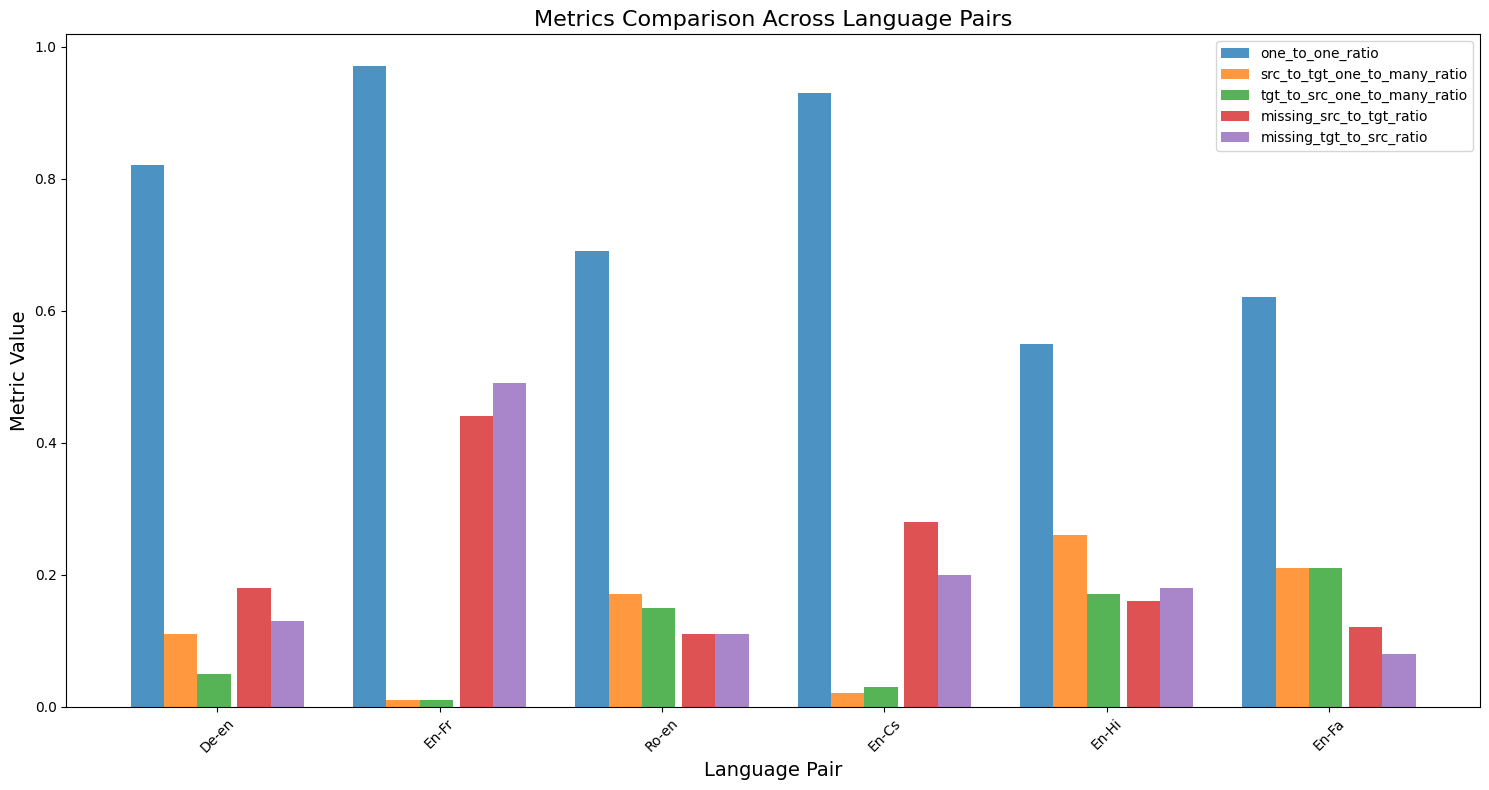

In [361]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_bars_with_spacing(data):
    # Adjusted order of metrics
    metrics = ['one_to_one_ratio', 'src_to_tgt_one_to_many_ratio', 'tgt_to_src_one_to_many_ratio', 'missing_src_to_tgt_ratio', 'missing_tgt_to_src_ratio']
    language_pairs = list(data.keys())

    # Number of groups and bars in each group
    n_groups = len(language_pairs)
    n_bars = len(metrics)

    # Create an array for the metric values for each language pair
    values = np.array([[data[lang_pair]['Corpus-level Metrics'][metric] for metric in metrics] for lang_pair in language_pairs])

    # Set up the figure and axes for the plot
    fig, ax = plt.subplots(figsize=(15, 8))

    # Set the positions of the bars and groups
    index = np.arange(n_groups)
    bar_width = 0.15
    opacity = 0.8
    spacing = 0.03  # Additional spacing after the third bar

    # Plotting each metric as a bar in each group
    for i, metric in enumerate(metrics):
        if i >= 3:  # Add spacing after the third metric
            additional_space = spacing
        else:
            additional_space = 0
        plt.bar(index + i*bar_width + additional_space, values[:, i], bar_width, alpha=opacity, label=metric)

    plt.xlabel('Language Pair', fontsize=14)
    plt.ylabel('Metric Value', fontsize=14)
    plt.title('Metrics Comparison Across Language Pairs', fontsize=16)
    plt.xticks(index + bar_width * (n_bars-1) / 2 + spacing/2, language_pairs, rotation=45)  # Adjust xticks to center them under groups
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_grouped_bars_with_spacing(data)
